# Intro to  Linear Regression with cuML

Corresponding notebook to [*Beginner’s Guide to Linear Regression in Python with cuML*](http://bit.ly/cuml_lin_reg_friend) story on Medium.

This notebook was tested using the `rapidsai/rapidsai-core-dev-nightly:22.04-cuda11.5-devel-ubuntu20.04-py3.9` container from [DockerHub](https://hub.docker.com/r/rapidsai/rapidsai-core-dev-nightly) and run on the NVIDIA GV100 GPU. Please be aware that your system may be different and you may need to modify the code or install packages to run the below examples. 

If you think you have found a bug or an error, please file an issue here:  https://github.com/rapidsai-community/notebooks-contrib/issues

Linear Regression is a simple machine learning model where the response `y` is modelled by a linear combination of the predictors in `X`. The `LinearRegression` function implemented in the `cuML` library allows users to change the `fit_intercept`, `normalize`, and `algorithm` parameters. 

Here is a brief on RAPIDS' Linear Regression parameters:

- `algorithm`: 'eig' or 'svd' (default = 'eig')
    - `Eig` uses a eigen decomposition of the covariance matrix, and is much faster
    - `SVD` is slower, but guaranteed to be stable
- `fit_intercept`: boolean (default = True)
  - If `True`, `LinearRegresssion` tries to correct for the global mean of `y`
  - If `False`, the model expects that you have centered the data.
- `normalize`: boolean (default = False)
  - If True, the predictors in X will be normalized by dividing by it’s L2 norm
  - If False, no scaling will be done

Methods that can be used with `LinearRegression` are:

- `fit`: Fit the model with `X` and `y`
- `get_params`: Sklearn style return parameter state
- `predict`: Predicts the `y` for `X`
- `set_params`: Sklearn style set parameter state to dictionary of params

`cuML`'s `LinearRegression` expects expects either `cuDF` DataFrame or `cuPy`/`NumPy` matrix inputs.

## Load data
- for this demo, we will be utilizing the Boston housing dataset from `sklearn`
  - start by loading in the set and printing a map of the contents

In [1]:
from sklearn.datasets import load_boston

# load Boston dataset
boston = load_boston()

# let's see what's inside
print(boston.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


#### Boston house prices dataset
- a description of the dataset is provided in `DESCR`
  - let's explore 

In [2]:
# what do we know about this dataset?
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### Build Dataframe
- Import `cuDF` and input the data into a DataFrame 
  - Then add a `PRICE` column equal to the `target` key

In [3]:
import cudf

# build dataframe from data key
bos = cudf.DataFrame(list(boston.data))
# set column names to feature_names
bos.columns = boston.feature_names

# add PRICE column from target
bos['PRICE'] = boston.target

# let's see what we're working with
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Split Train from Test
- For basic Linear Regression, we will predict `PRICE` (Median value of owner-occupied homes) based on `TAX` (full-value property-tax rate per $10,000)
  - Go ahead and trim data to just these columns

In [4]:
# simple linear regression X and Y
X = bos['TAX']
Y = bos['PRICE']

We can now set training and testing sets for our model
- Use `cuML`'s `train_test_split` to do this
  - Train on 70% of data
  - Test on 30% of data

In [5]:
from cuml.model_selection import train_test_split

# train/test split (70:30)
sX_train, sX_test, sY_train, sY_test = train_test_split(X, Y, train_size = 0.7)

# see what it looks like
print(sX_train.shape)
print(sX_test.shape)
print(sY_train.shape)
print(sY_test.shape)

(354,)
(152,)
(354,)
(152,)


### Predict Values
1. fit the model with `TAX` (*X_train*) and corresponding `PRICE` (*y_train*) values 
  - so it can build an understanding of their relationship 
2. predict `PRICE` (*y_test*) for a test set of `TAX` (*X_test*) values
  - and compare `PRICE` predictions to actual median house (*y_test*) values
    - use `sklearn`'s `mean_squared_error` to do this

In [6]:
from cuml import LinearRegression
from sklearn.metrics import mean_squared_error
import cupy

# call Linear Regression model
slr = LinearRegression()

# train the model
slr.fit(sX_train, sY_train)

# make predictions for test X values
sY_pred = slr.predict(sX_test)

# calculate error
mse = mean_squared_error(cupy.asnumpy(sY_test), 
                         cupy.asnumpy(sY_pred))
print(mse)

/opt/conda/envs/rapids/lib/python3.9/site-packages/cuml/internals/api_decorators.py:409: UserWarning: Changing solver from 'eig' to 'svd' as eig solver does not support training data with 1 column currently.
  return func(*args, **kwargs)


59.22383853242409


3. visualize prediction accuracy with `matplotlib`

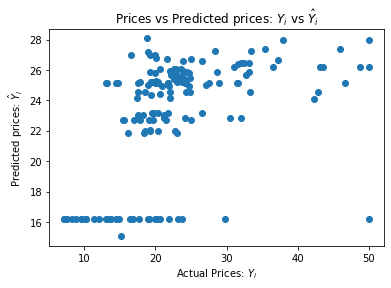

In [7]:

import matplotlib.pyplot as plt

# scatter actual and predicted results
plt.scatter(cupy.asnumpy(sY_test), cupy.asnumpy(sY_pred))

# label graph
plt.xlabel("Actual Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")

plt.show()

## Multiple Linear Regression 
- Our mean squared error for Simple Linear Regression looks kinda high.
  - Let's try Multiple Linear Regression (predicting based on multiple variables rather than just `TAX`) and see if that produces more accurate predictions

1. Set X to contain all values that are not `PRICE` from the unsplit data
  - i.e. `CRIM`, `ZN`, `INDUS`, `CHAS`, `NOX`, `RM`, `AGE`, `DIS`, `RAD`, `TAX`, `PTRATIO`, `B`, `LSTAT`
  - Y to still represent just 1 target value (`PRICE`)
    - also from the unsplit data


In [8]:
# set X to all variables except price
mX = bos.drop('PRICE', axis=1)
# and, like in the simple Linear Regression, set Y to price
mY = bos['PRICE']

2. Split the data into `multi_X_train`, `multi_X_test`, `Y_train`, and `Y_test`
  - Use `cuML`'s `train_test_split`
    - And the same 70:30 train:test ratio

In [9]:
# train/test split (70:30)
mX_train, mX_test, mY_train, mY_test = train_test_split(mX, mY, train_size = 0.7)

# see what it looks like
print(mX_train.shape)
print(mX_test.shape)
print(mY_train.shape)
print(mY_test.shape)

(354, 13)
(152, 13)
(354,)
(152,)


3. fit the model with `multi_X_train` and corresponding `PRICE` (*y_train*) values 
  - so it can build an understanding of their relationships 
4. predict `PRICE` (*y_test*) for the test set of independent (*multi_X_test*) values
  - and compare `PRICE` predictions to actual median house (*y_test*) values
    - use `sklearn`'s `mean_squared_error` to do this

In [10]:
# call Linear Regression model
mlr = LinearRegression()

# train the model for multiple regression
mlr.fit(mX_train, mY_train)

# make predictions for test X values
mY_pred = mlr.predict(mX_test)

# calculate error
mmse = mean_squared_error(cupy.asnumpy(mY_test), 
                         cupy.asnumpy(mY_pred))
print(mmse)

18.071493384532005


5. visualize with `matplotlib`

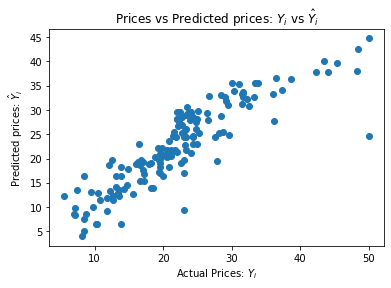

In [11]:
# scatter actual and predicted results
plt.scatter(cupy.asnumpy(mY_test), cupy.asnumpy(mY_pred))

# label graph
plt.xlabel("Actual Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")

plt.show()

## Conclusion
- looks like the multiple regression we ran does provide more accurate predictions than the simple linear regression
  - this will not always be the case, so always be sure to check and confirm if the extra computing is worth it

Anyways, that's how you implement both Simple and Multiple Linear Regression with `cuML`. Go forth and do great things. Thanks for stopping by!